# Transcrittore di file audio e link di YouTube
## Introduzione
Questo script usa Whisper, modello open source di OpenAI, e AssemblyAI per trascrivere con i più avanzati sistemi di voice-to-text basati su AI direttamente su Colab.

## Funzionamento
Tramite interafaccia guidata è possibile selezionare il modello da usare, il tipo di file che si vuole trascrivere (audio o link youtube), la lingua, l'inserimento della chiave API e altre istruzioni utili.

### Prima di iniziare
Il primo step è installare tutte le dipendenze una volta avviato il runtime

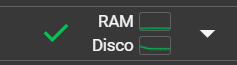

#### Whisper
Per poter usare Whisper non è necessario alcun intervento. Unica opzione non gestita dall'interfaccia guidata è quella di modificare il tipo di modello da usare alla riga che segue:

```
if transcription_engine == 'Whisper AI':
    model = whisper.load_model('large')
```

Se desideri una maggiore accuratezza, puoi utilizzare un modello più grande come 'medium' o 'large', oppure puoi usare 'base' che garantisce meno accuratezza ma alta velocità di trascrizione

#### AssemblyAI
Per utilizzare il modello esterno bisogna prima creare un account gratuito qui https://www.assemblyai.com/dashboard/signup e rilevare la propria chiave API nella dashboard principale. Verrà richiesta la chiave direttamente nell'interfaccia di esecuzione delle script.  

In [1]:
# Installazione dipendenze python necessarie

!pip install yt-dlp
!pip install ffmpeg
!pip install assemblyai
!pip install -U openai-whisper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.6/171.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 62.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=3c4cdb6c6bc7c68384b47cbc4c62e4b39a38a230043c5aad4109c9430e010b1c
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.6/72.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0

## Attenzione
Assicurati di aver eseguito la cella di prima per importare tutte le dipendenze altrimenti non potrai avviare la cella per la trascrizione.

In [4]:
import os
import shutil
import yt_dlp
import whisper
import requests
import time
from IPython.display import clear_output
from google.colab import files

def print_header(title):
    print("\n" + "="*60)
    print(f"{title.center(60)}")
    print("="*60 + "\n")

# Main Program
print_header("Transcription Tool")

# Step 1: Transcription engine selection
print("Please select the transcription engine:")
print("1) Whisper AI")
print("2) AssemblyAI")

while True:
    engine_choice = input("Enter 1 or 2: ")
    if engine_choice == '1':
        transcription_engine = 'Whisper AI'
        break
    elif engine_choice == '2':
        transcription_engine = 'AssemblyAI'
        assemblyai_api_key = input("Enter your AssemblyAI API key: ")
        break
    else:
        print("Invalid choice. Please enter 1 or 2.")

# Step 2: Language selection
print_header("Language Selection")
print("Please select the language:")
print("1) Auto-detect")
print("2) English")
print("3) Italian")
print("4) Spanish")
print("5) French")
print("6) German")

language_options = {
    '1': None,   # Auto-detect
    '2': 'en',   # English
    '3': 'it',   # Italian
    '4': 'es',   # Spanish
    '5': 'fr',   # French
    '6': 'de'    # German
}

while True:
    language_choice = input("Enter the number corresponding to the language: ")
    if language_choice in language_options:
        language = language_options[language_choice]
        break
    else:
        print("Invalid choice. Please enter a number between 1 and 6.")

# Step 3: Audio input handling
print_header("Audio Input Selection")
print("Please select the input:")
print("1) Upload audio file")
print("2) Enter YouTube link")

while True:
    input_choice = input("Enter 1 or 2: ")
    if input_choice == '1':
        # Upload audio file
        print("\nPlease upload your audio file:")
        uploaded = files.upload()
        if not uploaded:
            print("No file uploaded.")
            exit()
        uploaded_file = list(uploaded.keys())[0]
        audio_path = uploaded_file
        title = input("Enter the title for the uploaded file: ")
        folder_name = title.replace(" ", "_")
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)
        shutil.move(uploaded_file, folder_name)
        audio_path = os.path.join(folder_name, uploaded_file)
        break
    elif input_choice == '2':
        youtube_link = input("Enter the YouTube link: ")
        print("\nFetching video information...")
        # Get the title from the YouTube video
        ydl_opts = {'quiet': True}
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            info_dict = ydl.extract_info(youtube_link, download=False)
            title = info_dict.get('title', None)
        print(f"Video title: {title}")
        # Create folder and download audio
        folder_name = title.replace(" ", "_")
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)
        print("\nDownloading audio...")
        ydl_opts = {
            'format': 'bestaudio/best',
            'outtmpl': f'{folder_name}/%(title)s.%(ext)s',
            'postprocessors': [{
                'key': 'FFmpegExtractAudio',
                'preferredcodec': 'wav',
                'preferredquality': '192',
            }],
            'quiet': False,
            'no_warnings': True,
        }
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([youtube_link])
        # Find the downloaded audio file
        audio_path = None
        for file in os.listdir(folder_name):
            if file.endswith('.wav'):
                audio_path = os.path.join(folder_name, file)
                break
        if audio_path is None:
            print("Error: audio file not found.")
            exit()
        break
    else:
        print("Invalid choice. Please enter 1 or 2.")

# Step 4: Transcribe audio
print_header("Transcription in Progress")
print("Please wait while your audio is being transcribed...\n")

if transcription_engine == 'Whisper AI':
    model = whisper.load_model('large')
    if language:
        result = model.transcribe(audio_path, language=language)
    else:
        result = model.transcribe(audio_path)
    transcription = result['text']
    summary = ""  # Whisper does not generate summary
elif transcription_engine == 'AssemblyAI':
    headers = {
        'authorization': assemblyai_api_key,
    }
    # Upload audio file
    print("Uploading audio file to AssemblyAI...")
    upload_url = 'https://api.assemblyai.com/v2/upload'
    with open(audio_path, 'rb') as f:
        response = requests.post(upload_url, headers=headers, data=f)
    response_data = response.json()
    if response.status_code != 200:
        print("Error uploading audio file:", response_data)
        exit()
    audio_url = response_data['upload_url']

    # Request transcription
    print("Requesting transcription from AssemblyAI...")
    transcribe_url = 'https://api.assemblyai.com/v2/transcript'
    json_data = {
        'audio_url': audio_url
    }

    if language:
        json_data['language_code'] = language
        if language != 'en_us':
            json_data['language_model'] = 'multilingual'
        else:
            # Enable summarization only if language is English
            json_data['summarization'] = True
            json_data['summary_type'] = "bullets"
            json_data['summary_model'] = "informative"
    else:
        # Assume English and enable summarization
        json_data['summarization'] = True
        json_data['summary_type'] = "bullets"
        json_data['summary_model'] = "informative"

    response = requests.post(transcribe_url, headers=headers, json=json_data)
    response_data = response.json()
    if response.status_code != 200:
        print("Error requesting transcription:", response_data)
        exit()
    if 'id' not in response_data:
        print("Error: API did not return a transcription ID.")
        print("API response:", response_data)
        exit()
    transcription_id = response_data['id']
    # Wait for transcription to complete
    print("\nTranscription in progress...")
    transcript_url = f'{transcribe_url}/{transcription_id}'
    while True:
        response = requests.get(transcript_url, headers=headers)
        response_data = response.json()
        if response.status_code != 200:
            print("Error retrieving transcription:", response_data)
            exit()
        status = response_data['status']
        if status == 'completed':
            transcription = response_data['text']
            summary = response_data.get('summary', '')
            break
        elif status == 'failed':
            print("Error in transcription:", response_data)
            transcription = ""
            summary = ""
            break
        else:
            print(f"Transcription status: {status}. Please wait...")
        time.sleep(5)

# Step 5: Save results
print_header("Transcription Completed")
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
transcription_file = os.path.join(folder_name, 'transcription.txt')
with open(transcription_file, 'w') as f:
    f.write(transcription)
print(f"Transcription completed successfully!\n")
print(f"Transcription saved at: {transcription_file}")

if transcription_engine == 'AssemblyAI' and summary:
    summary_file = os.path.join(folder_name, 'summary.txt')
    with open(summary_file, 'w') as f:
        f.write(summary)
    print(f"\nSummary generated and saved at: {summary_file}")

# Optionally display the transcription
display_option = input("\nWould you like to display the transcription? (y/n): ")
if display_option.lower() == 'y':
    print("\n" + "-"*60)
    print("Transcription:")
    print("-"*60 + "\n")
    print(transcription)
    print("\n" + "-"*60)

# Provide download links
print("\nYou can download the transcription file from the Files tab on the left.")
print("Alternatively, you can download it directly:")

files.download(transcription_file)

if transcription_engine == 'AssemblyAI' and summary:
    summary_option = input("\nWould you like to display the summary? (y/n): ")
    if summary_option.lower() == 'y':
        print("\n" + "-"*60)
        print("Summary:")
        print("-"*60 + "\n")
        print(summary)
        print("\n" + "-"*60)
    print("\nDownloading summary file...")
    files.download(summary_file)



                     Transcription Tool                     

Please select the transcription engine:
1) Whisper AI
2) AssemblyAI
Enter 1 or 2: 2
Enter your AssemblyAI API key: b9dabcb2b85842c990c3df421e988086

                     Language Selection                     

Please select the language:
1) Auto-detect
2) English
3) Italian
4) Spanish
5) French
6) German
Enter the number corresponding to the language: 3

                   Audio Input Selection                    

Please select the input:
1) Upload audio file
2) Enter YouTube link
Enter 1 or 2: 1

Please upload your audio file:


Saving Addio Google Workspace, ho trovato DI MEGLIO..wav to Addio Google Workspace, ho trovato DI MEGLIO..wav
Enter the title for the uploaded file: Addio Google Workspace, ho trovato DI MEGLIO..wav to Addio Google Workspace, ho trovato DI MEGLIO

                 Transcription in Progress                  

Please wait while your audio is being transcribed...

Uploading audio file to AssemblyAI...
Requesting transcription from AssemblyAI...

Transcription in progress...
Transcription status: queued. Please wait...
Transcription status: processing. Please wait...
Transcription status: processing. Please wait...
Transcription status: processing. Please wait...
Transcription status: processing. Please wait...
Transcription status: processing. Please wait...
Transcription status: processing. Please wait...
Transcription status: processing. Please wait...
Transcription status: processing. Please wait...
Transcription status: processing. Please wait...
Transcription status: processing. Plea

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>